In [60]:
import numpy as np
import matplotlib.pyplot as plt
from ML_for_GreenImaging.PipelineStages import *
from tensorflow.keras import models, optimizers, layers, metrics

In [61]:
def architecture_1(input_shape, n_filters, filter_size):
    network = models.Sequential()
    network.add(layers.Input(shape=(*input_shape, 1)))
    network.add(layers.Conv2D(n_filters[0], filter_size[0], strides=1, activation='relu'))
    network.add(layers.Conv2D(n_filters[1], filter_size[1], strides=1, activation='relu'))
    network.add(layers.Flatten())
    network.add(layers.Dense(2, activation='sigmoid'))
    return network

In [62]:
path = "/Users/jackmango/Desktop/QUIRP - Work/Princeton/Data/06:23:23/imaging exposure time = 25ms"
model = models.load_model(path + "/model1.h5")

In [63]:
loader = Loader.Loader(100, 20, path, path + "/model1.h5")
stack, tot_loops, info = loader.run()

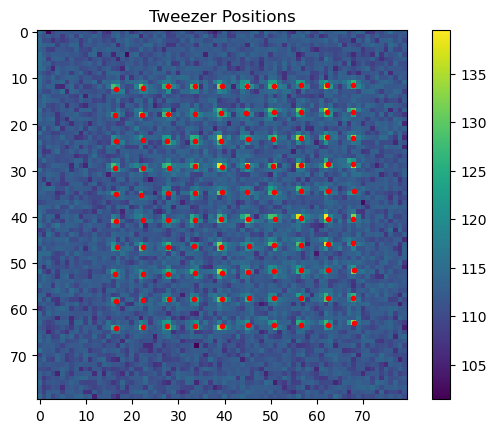

In [64]:
processor = ImageProcessing.ImageProcessor(stack, 100, tot_loops)
crops3x3, crops1x1, positions, info = processor.run()

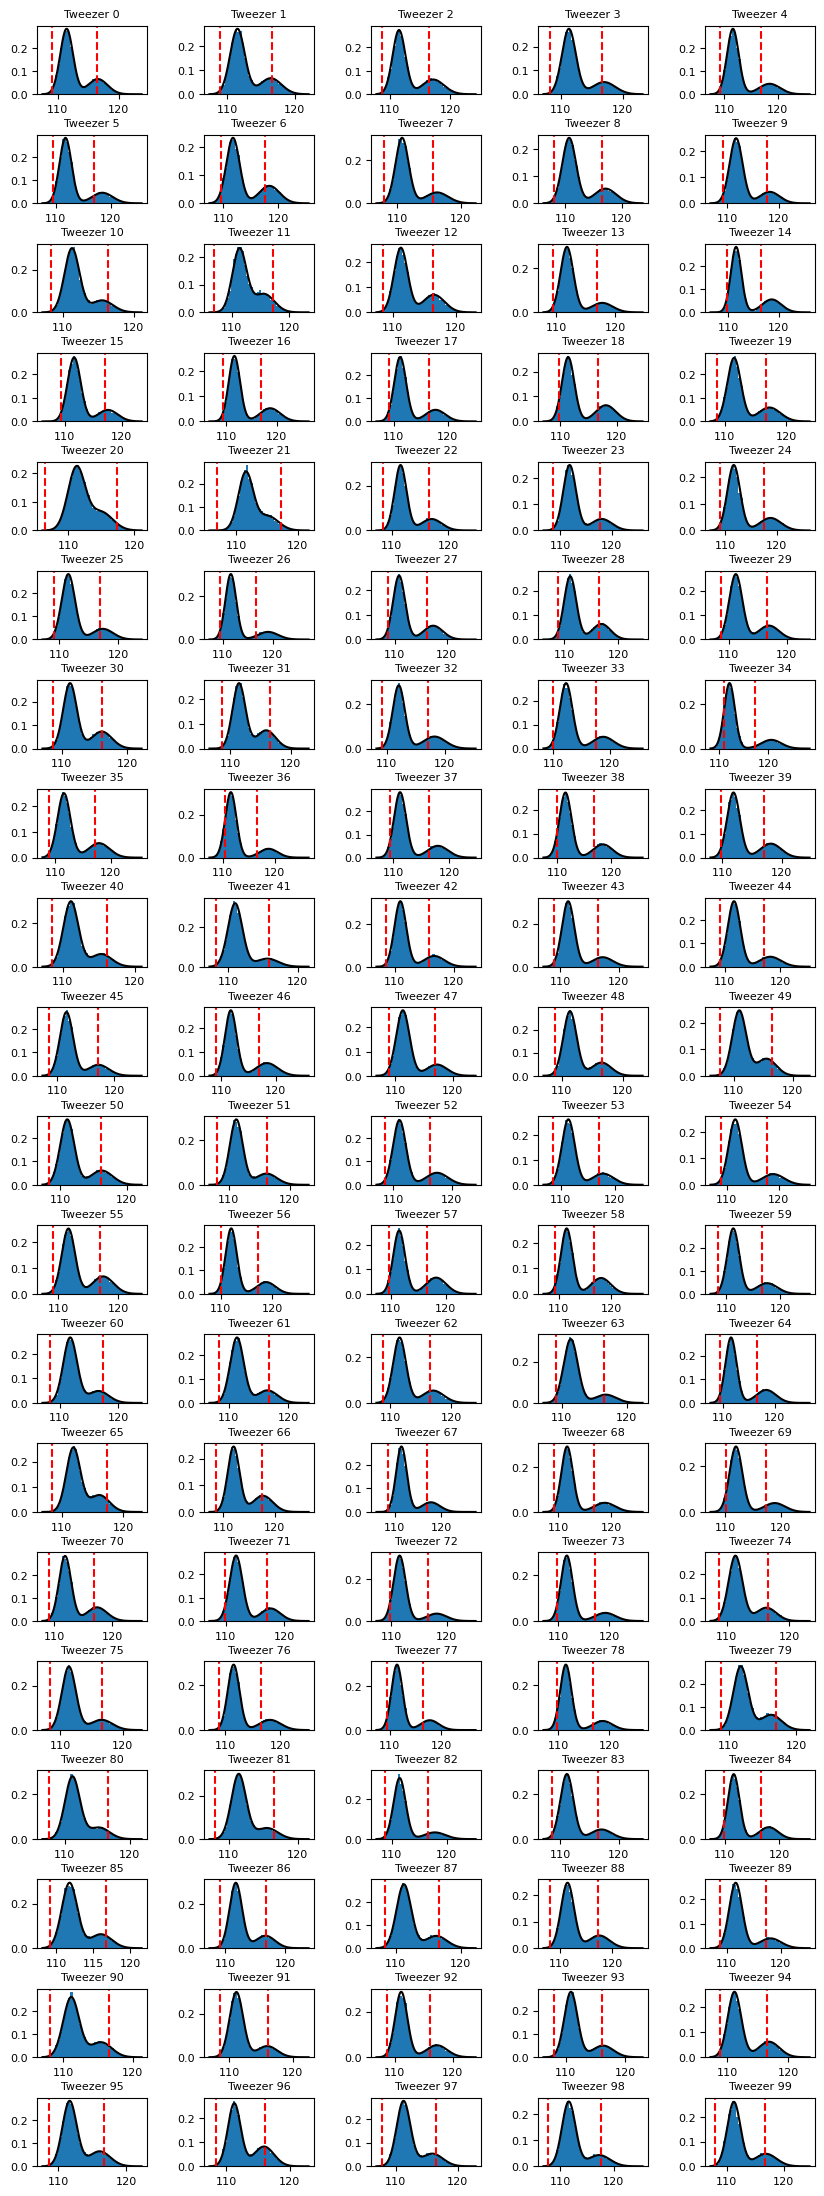

In [65]:
labeler = Labeler.Labeler(crops1x1, 100, tot_loops)
labels, info = labeler.run()

In [66]:
# Separate labels and crops for each site
crops3x3 = np.reshape(crops3x3, (100, *crops3x3.shape[1:]))
labels = np.transpose(np.array([np.absolute(labels - 1), labels]))
labels = np.reshape(labels, (100, -1, 2))
bad = np.isnan(labels)
keep = ~ bad
labels = [site_labels[site_keep[:, 0]] for site_labels, site_keep in zip(labels, keep)]
crops = [site_crops[site_keep[:, 0]] for site_crops, site_keep in zip(crops3x3, keep)]

In [67]:
# Randomly select 10% of each dataset for evaluation
def make_dataset(labels, crops, n_samples, tweezer_weight):
  testing = []
  training = []
  img_width = crops[0].shape[1]
  img_height = crops[0].shape[2]
  for tweezer_labels, tweezer_crops in zip(labels, crops):
      n_testing = int(0.1 * tweezer_labels.shape[0])
      n_training = tweezer_labels.shape[0] - n_testing
      testing_indices = np.random.choice(tweezer_labels.shape[0], n_testing, replace=False)
      testing.append([tweezer_crops[testing_indices], tweezer_labels[testing_indices]])
      training.append([np.delete(tweezer_crops, testing_indices, axis=0),
                       np.delete(tweezer_labels, testing_indices, axis=0),
                       tweezer_weight * (n_samples / n_training) * np.ones(n_training)])
  for i in range(100):
    other_tweezer_crops = np.concatenate([training[i][0] for j in range(100) if j != i])
    other_tweezer_labels = np.concatenate([training[i][1] for j in range(100) if j != i])
    other_tweezer_crops = np.reshape(other_tweezer_crops, (-1, img_width, img_height))
    sample_indices = np.random.choice(other_tweezer_crops.shape[0], size=n_samples, replace=False)
    training[i][0] = np.append(training[i][0], other_tweezer_crops[sample_indices], axis=0)
    training[i][1] = np.append(training[i][1], other_tweezer_labels[sample_indices], axis=0)
    training[i][2] = np.append(training[i][2], np.ones(n_samples), axis=0)
  return testing, training  

In [68]:
def multi_tweezer_fidelity(networks, crops):
  p_db = []
  p_bd = []
  for i, (network, crops) in enumerate(zip(networks, crops)):
    print(f"Tweezer Number {i}")
    occ = np.argmax(network.predict(crops), axis=1)
    occ = np.reshape(occ, (tot_loops, -1))
    diff = np.diff(occ, axis=1)
    n_dark_to_bright = np.sum(diff == -1)
    n_dark = np.sum(occ[:,:-1] == 0)
    n_bright_to_dark = np.sum(diff == 1)
    n_bright = np.sum(occ[:,:-1] == 1)
    p_db.append(n_dark_to_bright / n_dark)
    p_bd.append(n_bright_to_dark / n_bright)
  p_db = np.array(p_db)
  p_bd = np.array(p_bd) 
  return p_db, p_bd

def test_weighting(labels, crops, test_values):
    p_db = []
    p_bd = []
    for test_val in test_values:
        testing, training = make_dataset(labels, crops, 20000, test_val)
        networks = [architecture_1(crops3x3.shape[2:], [10, 10], [3, 3]) for i in range(100)]
        tweezer_metrics = []
        for i, tweezer_network in enumerate(networks):
            print(f"Tweezer {i}")
            tweezer_network.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
            tweezer_network.fit(*training[i][:2], sample_weight=training[i][2], epochs=6)
            tweezer_metrics.append(tweezer_network.evaluate(*testing[i]))
        exp_p_db, exp_p_bd = multi_tweezer_fidelity(networks, crops3x3)
        p_db.append(np.mean(exp_p_db))
        p_bd.append(np.mean(exp_p_bd))
    return p_db, p_bd

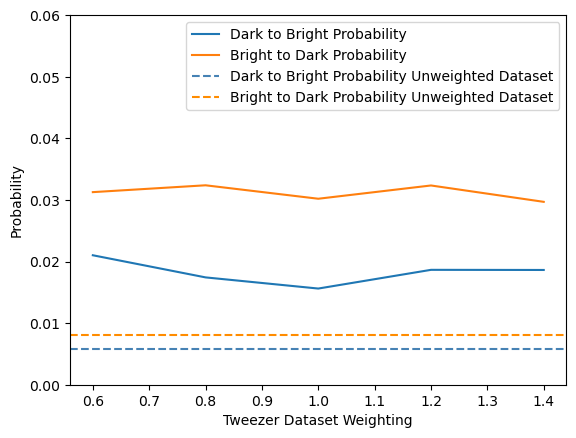

In [80]:
#test_vals = np.linspace(0.6, 1.4, 5)

#p_db, p_bd = test_weighting(labels, crops, test_vals)

plt.plot(test_vals, p_db, label="Dark to Bright Probability")
plt.plot(test_vals, p_bd, label="Bright to Dark Probability")
plt.axhline(0.00581, label="Dark to Bright Probability Unweighted Dataset", color='steelblue', linestyle='--')
plt.axhline(0.00811, label="Bright to Dark Probability Unweighted Dataset", color='darkorange', linestyle='--')
plt.ylim(0, 0.06)
plt.xlabel("Tweezer Dataset Weighting")
plt.ylabel("Probability")
plt.legend()

Tweezer 0
Epoch 1/6
1012/1012 [==============================] - 6s 5ms/step - loss: 0.6365 - binary_accuracy: 0.8275 - true_positives_101: 26754.0000 - true_negatives_101: 26796.0000 - false_positives_101: 5560.0000 - false_negatives_101: 5602.0000
Epoch 2/6
1012/1012 [==============================] - 5s 5ms/step - loss: 0.0750 - binary_accuracy: 0.9810 - true_positives_101: 31738.0000 - true_negatives_101: 31746.0000 - false_positives_101: 610.0000 - false_negatives_101: 618.0000
Epoch 3/6
1012/1012 [==============================] - 5s 5ms/step - loss: 0.0401 - binary_accuracy: 0.9915 - true_positives_101: 32078.0000 - true_negatives_101: 32084.0000 - false_positives_101: 272.0000 - false_negatives_101: 278.0000
Epoch 4/6
1012/1012 [==============================] - 5s 5ms/step - loss: 0.0296 - binary_accuracy: 0.9940 - true_positives_101: 32162.0000 - true_negatives_101: 32163.0000 - false_positives_101: 193.0000 - false_negatives_101: 194.0000
Epoch 5/6
1012/1012 [===============

Tweezer Number 0
810/810 [==============================] - 1s 1ms/step
Tweezer Number 1
810/810 [==============================] - 1s 1ms/step
Tweezer Number 2
810/810 [==============================] - 1s 1ms/step
Tweezer Number 3
810/810 [==============================] - 1s 1ms/step
Tweezer Number 4
810/810 [==============================] - 1s 1ms/step
Tweezer Number 5
810/810 [==============================] - 1s 1ms/step
Tweezer Number 6
810/810 [==============================] - 1s 1ms/step
Tweezer Number 7
810/810 [==============================] - 1s 1ms/step
Tweezer Number 8
810/810 [==============================] - 1s 1ms/step
Tweezer Number 9
810/810 [==============================] - 1s 1ms/step
Tweezer Number 10
810/810 [==============================] - 1s 1ms/step
Tweezer Number 11
810/810 [==============================] - 1s 1ms/step
Tweezer Number 12
810/810 [==============================] - 1s 1ms/step
Tweezer Number 13
810/810 [==============================] - 

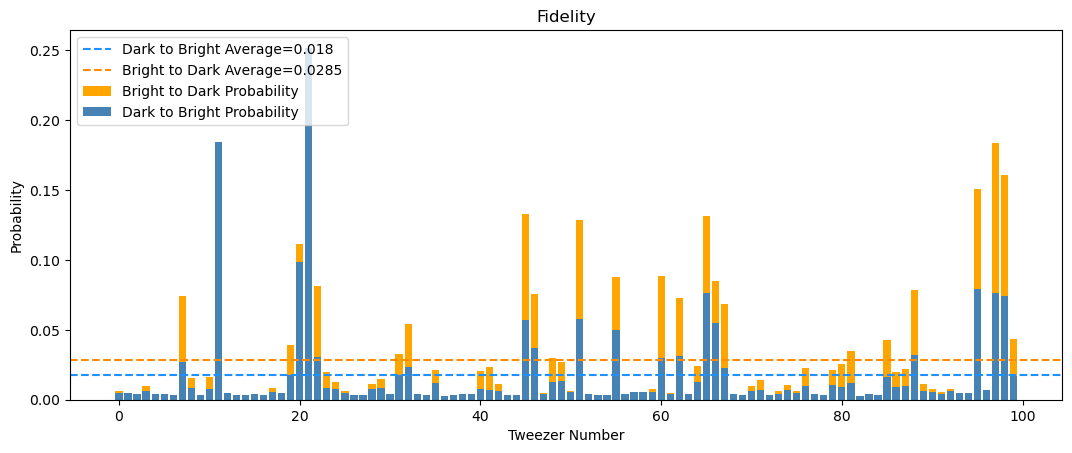

<Figure size 640x480 with 0 Axes>

In [29]:


plt.figure(figsize=(12.8, 4.8))
plt.bar(np.arange(100), p_bd, label=f'Bright to Dark Probability', color='orange')
plt.bar(np.arange(100), p_db, label=f'Dark to Bright Probability', color='steelblue')
plt.axhline(p_db.mean(), label=f"Dark to Bright Average={np.mean(p_db):.3}", color='dodgerblue', linestyle='--')
plt.axhline(p_bd.mean(), label=f"Bright to Dark Average={np.mean(p_bd):.3}", color='darkorange', linestyle='--')
plt.xlabel('Tweezer Number')
plt.ylabel('Probability')
plt.legend(loc='upper left')
plt.title('Fidelity')
plt.show()
plt.savefig(path + "/figure2.png")

In [56]:
half = np.array([
    [0.1000, 0.0116, 0.00560],		
    [ 0.0662, 0.019, 0.00504,]
])

quarter = np.array([
    [0.0873, 0.0115, 0.00523],
    [0.0688, 0.0192, 0.004]
])

none = np.array([
    [0.0383, 0.00581, 0.00506],		
    [0.0828, 0.00811, 0.00374]
])

times = np.array([20, 25, 30])

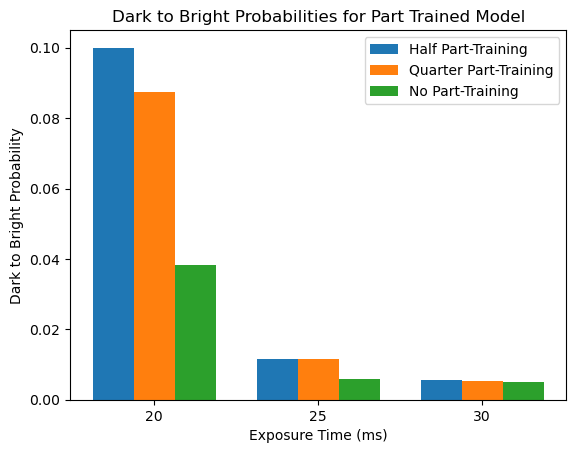

In [57]:
r = np.arange(3)
plt.bar(r, half[0], width=0.25, label="Half Part-Training")
plt.bar(r + 0.25, quarter[0], width=0.25, label="Quarter Part-Training")
plt.bar(r + 0.5, none[0], width=0.25, label="No Part-Training")
plt.xticks(0.25 + np.arange(3), [20, 25, 30])
plt.xlabel("Exposure Time (ms)")
plt.ylabel("Dark to Bright Probability")
plt.title("Dark to Bright Probabilities for Part Trained Model")
plt.legend()


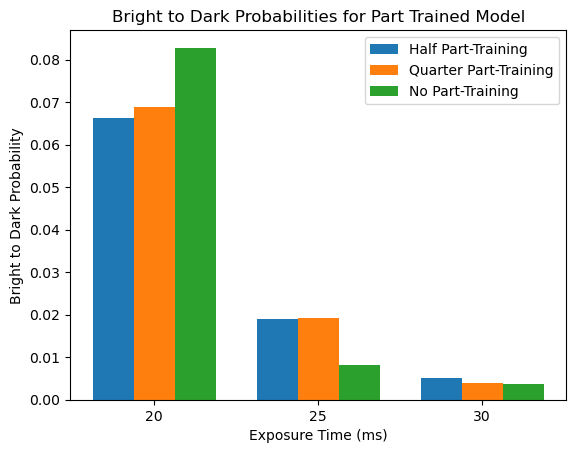

In [58]:
r = np.arange(3)
plt.bar(r, half[1], width=0.25, label="Half Part-Training")
plt.bar(r + 0.25, quarter[1], width=0.25, label="Quarter Part-Training")
plt.bar(r + 0.5, none[1], width=0.25, label="No Part-Training")
plt.xticks(0.25 + np.arange(3), [20, 25, 30])
plt.xlabel("Exposure Time (ms)")
plt.ylabel("Bright to Dark Probability")
plt.title("Bright to Dark Probabilities for Part Trained Model")
plt.legend()
